In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d chopinforest1986/regular-deepdrid

In [ ]:
! unzip -q '/content/regular-deepdrid.zip'

In [ ]:
import os
import cv2
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence

In [ ]:
from albumentations import Compose, OneOf, CLAHE, Flip, Transpose, Rotate, RGBShift, RandomBrightnessContrast, RandomGamma

In [ ]:
from sklearn.metrics import classification_report, cohen_kappa_score

In [ ]:
train_df = pd.read_csv('/content/DR_label/DR_label/regular-fundus-training.csv')
valid_df = pd.read_csv('/content/DR_label/DR_label/regular-fundus-validation.csv')

In [ ]:
train_df = train_df.fillna(0)
train_df['diagnosis'] = train_df['left_eye_DR_Level'] + train_df['right_eye_DR_Level']
train_df = train_df[['image_id', 'diagnosis']]

valid_df = valid_df.fillna(0)
valid_df['diagnosis'] = valid_df['left_eye_DR_Level'] + valid_df['right_eye_DR_Level']
valid_df = valid_df[['image_id', 'diagnosis']]

In [ ]:
IMG_SIZE = 224

In [ ]:
train_images = []
train_labels = []

for img_id, diagnosis in zip(train_df['image_id'], train_df['diagnosis']):
  
  path = f'Regular_DeepDRiD/regular_train/{img_id}.jpg'
  
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
  
  train_images.append(img)
  train_labels.append(np.eye(5)[int(diagnosis)])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
valid_images = []
valid_labels = []

for img_id, diagnosis in zip(valid_df['image_id'], valid_df['diagnosis']):
  
  path = f'Regular_DeepDRiD/regular_valid/{img_id}.jpg'
  
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
  
  valid_images.append(img)
  valid_labels.append(np.eye(5)[int(diagnosis)])

valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

In [ ]:
for i in range(10):
  seed = 100*i
  np.random.seed(seed)
  np.random.shuffle(train_images)
  np.random.seed(seed)
  np.random.shuffle(train_labels)
  np.random.seed(seed)
  np.random.shuffle(valid_images)
  np.random.seed(seed)
  np.random.shuffle(valid_labels)

In [ ]:
class Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=1, split='train', augment=True):
    self.x = x_set
    self.y = y_set
    self.batch_size = batch_size
    self.split = split
    self.augment = augment
    self.preprocessing = CLAHE(always_apply=True, p=1.0)
    self.augmentations = Compose(
    [
      OneOf([
              Flip(),
              Transpose(),
              Rotate(border_mode=0)
            ], p=0.9),
      OneOf([
              RandomBrightnessContrast(),
              RandomGamma(),
              RGBShift(),
            ], p=0.3)
    ])

  def __len__(self):
    return math.ceil(len(self.x) / self.batch_size)

  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

    if self.augment is True:
      if self.split=='train':
        batch_x = np.array([self.augmentations(image=i)['image'] for i in batch_x])
      batch_x = np.array([self.preprocessing(image=i)['image'] for i in batch_x])

    return batch_x/255, batch_y

In [ ]:
batch_size = 16

def train_generator_func():
  generator = Generator(train_images, train_labels, batch_size, 'train', True)
  return generator

def valid_generator_func():
  generator = Generator(valid_images, valid_labels, batch_size, 'valid', True)
  return generator


train_generator = tf.data.Dataset.from_generator(
    train_generator_func,
    output_types=(tf.float32, tf.float32),
    output_shapes=((None, IMG_SIZE, IMG_SIZE, 3), (None , 5))
).repeat().prefetch(tf.data.experimental.AUTOTUNE)

valid_generator = tf.data.Dataset.from_generator(
    valid_generator_func,
    output_types=(tf.float32, tf.float32),
    output_shapes=((None, IMG_SIZE, IMG_SIZE, 3), (None, 5))
).prefetch(tf.data.experimental.AUTOTUNE)

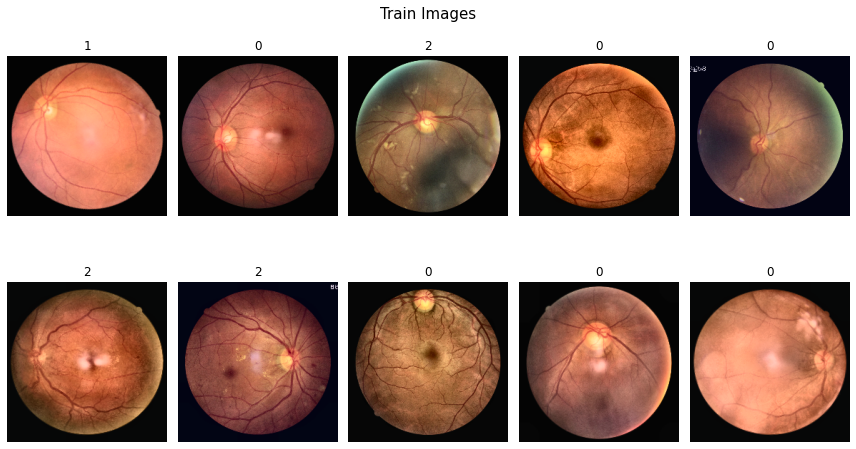

In [ ]:
for i, j in train_generator:
  break

fig, axes = plt.subplots(2, 5, figsize=(12, 7))
fig.suptitle('Train Images', fontsize=15)
axes = axes.flatten()
for img, lbl, ax in zip(i[:10], j[:10], axes):
    ax.imshow(img)
    ax.title.set_text(str(int(np.argmax(lbl))))
    ax.axis('off')
plt.tight_layout()
plt.show()

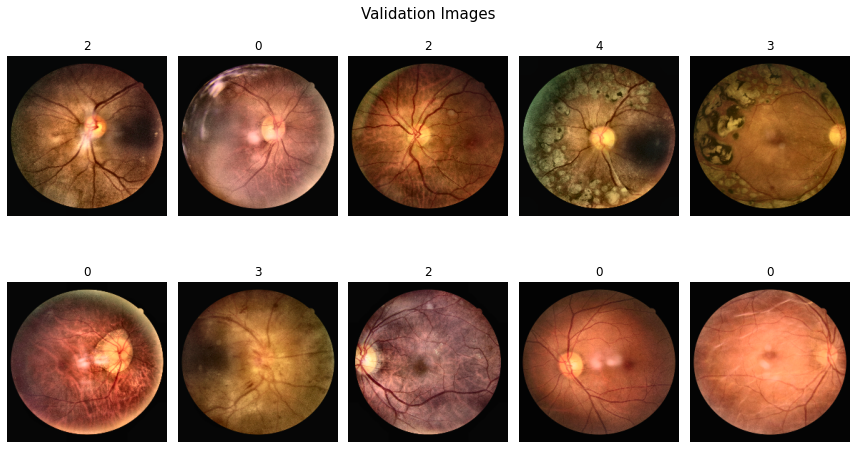

In [ ]:
for i, j in valid_generator:
  break

fig, axes = plt.subplots(2, 5, figsize=(12, 7))
fig.suptitle('Validation Images', fontsize=15)
axes = axes.flatten()
for img, lbl, ax in zip(i[:10], j[:10], axes):
    ax.imshow(img)
    ax.title.set_text(str(int(np.argmax(lbl))))
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def kappa(y_true, y_pred):
  y_true = np.argmax(y_true, axis=-1)
  y_pred = np.argmax(y_pred, axis=-1)
  kappa_score = cohen_kappa_score(y_true, y_pred, weights='quadratic')
  return kappa_score

def tf_kappa(y_true, y_pred):
  kappa_score = tf.py_function(func=kappa, inp=[y_true, y_pred], Tout=tf.float32)
  return kappa_score

In [ ]:
base_model = tf.keras.applications.DenseNet201(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                            include_top=False,
                                            weights='imagenet')

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.GlobalAveragePooling2D(),
                              tf.keras.layers.Dense(512, activation='relu'),
                              tf.keras.layers.Dropout(rate=0.2),
                              tf.keras.layers.Dense(512, activation='relu'),
                              tf.keras.layers.Dropout(rate=0.2),
                              tf.keras.layers.Dense(128, activation='relu'),
                              tf.keras.layers.Dropout(rate=0.2),
                              tf.keras.layers.Dense(128, activation='relu'),
                              tf.keras.layers.Dropout(rate=0.2),
                              tf.keras.layers.Dense(5, activation='softmax'),
                              ])

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1920)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               983552    
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_31 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)             

In [ ]:
base_model.trainable = False

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf_kappa])

In [ ]:
steps_per_epoch = (2*len(train_images))//batch_size
validation_steps = len(valid_images)//batch_size
epochs = 20
initial_epoch = 0

history = model.fit(
  x=train_generator,
  steps_per_epoch=steps_per_epoch,
  initial_epoch=initial_epoch,
  epochs=epochs,
  validation_data=valid_generator, 
  validation_steps=validation_steps,
  verbose=1,
)

Epoch 1/20
150/150 [==============================] - 35s 231ms/step - loss: 1.3288 - accuracy: 0.4737 - tf_kappa: 0.2076 - val_loss: 1.1360 - val_accuracy: 0.5600 - val_tf_kappa: 0.4862
Epoch 2/20
150/150 [==============================] - 31s 206ms/step - loss: 1.1380 - accuracy: 0.5358 - tf_kappa: 0.5212 - val_loss: 1.0301 - val_accuracy: 0.6050 - val_tf_kappa: 0.6327
Epoch 3/20
150/150 [==============================] - 31s 206ms/step - loss: 1.0732 - accuracy: 0.5508 - tf_kappa: 0.5793 - val_loss: 1.0103 - val_accuracy: 0.6275 - val_tf_kappa: 0.6580
Epoch 4/20
150/150 [==============================] - 31s 206ms/step - loss: 1.0200 - accuracy: 0.5813 - tf_kappa: 0.6142 - val_loss: 1.0143 - val_accuracy: 0.6050 - val_tf_kappa: 0.6315
Epoch 5/20
150/150 [==============================] - 31s 206ms/step - loss: 0.9916 - accuracy: 0.5892 - tf_kappa: 0.6441 - val_loss: 0.9830 - val_accuracy: 0.6125 - val_tf_kappa: 0.6668
Epoch 6/20
150/150 [==============================] - 31s 206ms/s

In [ ]:
len(base_model.layers)

In [ ]:
fine_tune_at = 650
for layer in base_model.layers[fine_tune_at:]:
  layer.trainable =  True

In [ ]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf_kappa])

In [ ]:
steps_per_epoch = (2*len(train_images))//batch_size
validation_steps = len(valid_images)//batch_size
epochs = 50
initial_epoch = 20

history = model.fit(
  x=train_generator,
  steps_per_epoch=steps_per_epoch,
  initial_epoch=initial_epoch,
  epochs=epochs,
  validation_data=valid_generator, 
  validation_steps=validation_steps,
  verbose=1,
)

In [ ]:
test_generator = Generator(valid_images, valid_labels, len(valid_images), False)

In [ ]:
for x_test, y_test in test_generator:
  break

In [ ]:
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(x_test), axis=-1)

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
print(cohen_kappa_score(y_true, y_pred, weights='quadratic'))